# Why Differential Validity Measures May Not Mean Your Model is Discriminatory

Nicholas Schmidt, SolasAI & BLDS, LLC

August 6, 2023

## Introduction

Discrimination against a group of people or against individuals can be conceptualized in a number of different ways. These include disparate treatment, disparate impact, proxy discrimination, differential prediction, and differential validity. Here, we will focus on differential validity. This is measured as the difference or ratio of one group's model quality measurement to that of another group. For example, we might look at relative AUC scores for an employment hiring model, comparing the AUC for Black applicants to that of white applicants. If the AUC for the Black applicants is substantially lower than that for the white applicants, then there is evidence that the model is differentially valid. It is then assumed that _the model_ must be discriminatory because it is less effective for Black applicants relative to whites. 

In this notebook, we create a simple example that proves that differential validity measures can be misleading. Instead of just being the result of a bad model, differential validity may arise naturally as the result of differences in the distribution of input data from one group to another - differences which may not be discriminatory or may be outside the control of the modeler or company performing the modeling.

Below, we create a synthetic dataset with a few simple variables meant to mimic an employment hiring process. The idea is that we are a company that wants to identify and hire "highly productive" employees. To do this, we use this dataset to create a model that uses work experience and an additional factor to predict whether an employee will be highly productive. The company would use the model by scoring prospective employees and hiring those with the highest scores.

With this synthetic dataset and model, we show that a well-built model can still show evidence of differential validity. In particular, _evidence of differential validity occurs when an input variable has lower variance for one group relative to another, even when the model accurately captures the true data generating process for all groups_. This is important because it means that differential validity as a measure of model-based discrimination can be misleading. There may be non-model-related, and possibly non-discriminatory, reasons why a model should show differential validity. The converse is also true: a bad model that does not show evidence of differential validity may still be a discriminatory model. Therefore, only looking at measures of differential validity is not sufficient to identify discrimination. Instead, we should be concerned with (1) ensuring that the model accurately captures the data generating process, (2) determining whether that data generating process is itself discriminatory, and (3) determining whether the usage of the model is discriminatory. 

The code and example below show how an otherwise accurate model can show evidence of differential validity. If you are not comfortable with Python code, feel free to ignore it - the text will sufficiently explain what the code is doing.

## Create the Dataset

We first start by creating the synthetic dataset that will be used for the model and differential validity assessment. The advantage of using this synthetic dataset is that we know exactly what the data generating process is, which means we can make a model that perfectly replicates that process. In other words, we will know that the model that we will build will be the best model possible.

Before proceeding, we will define the _data generating process_ as the process that causes the data to occur as they do. Here, the synthetic data are created (or "generated") using chosen distributions and parameters. As such, we know what the inputs will be, and we also know how the inputs work to create the output (i.e., how the variables work together to form the `Highly Productive` outcome). We will also know exactly how uncertainty comes into the process. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(31415)

The dataset we create has three influential factors. The first is the employee's `Experience`, which might be the time spent working on the job, tenure, or some other measure of experience. The second variable is a vaguely defined `Other Factor` that is important for determining productivity. This might be something like specialized training, education, or something else. What the factor specifically represents is not important for this hypothetical example -- we include it because we want to have multiple variables in the model. These two variables represent all the measurable information that the company has that can be used to predict whether a person is highly productive. Of course, there are other unmeasurable factors. These are captured in the `Unmeasurable Factors` variable which corresponds to the noise or uncertainty of the process. Importantly, these unmeasurable factors are independent of both race and the measurable factors.

We also create `Minority` and `Majority` variables. These are created to be entirely unrelated to the other variables in the model, except that we change the variance of the `Experience` variable for minorities in the next step.

In [2]:
data = np.random.randn(250000, 2)
data = pd.DataFrame(data=data, columns=['Experience', 'Other Factor'])
data['Unmeasurable Factors'] = np.random.logistic(0, 1, len(data))
data['Minority'] = np.random.choice([0, 1], len(data))
data['Majority'] = 1 - data['Minority']

The step below is the key for generating differential validity in an otherwise accurate and potentially non-discriminatory model. For minorities, we reduce the variation in the `Experience` variable by one-half. Importantly, this does not change the average level of experience for minorities. The effect is that there are fewer minorities with very little experience, but there are also fewer minorities with large amounts of experience. Whether this change represents a non-discriminatory impact is questionable, but it is certainly outside the control of the modeler.

For both groups, we add 10 to the `Experience` variable, which makes the average experience equal to 10 years. This is done to make the variable appear more realistic, but does not impact results.

In [3]:
data.loc[data['Minority'] == 1, 'Experience'] = \
data.loc[data['Minority'] == 1, 'Experience'] * 0.5
data['Experience'] = data['Experience'] + 10

We now complete the data generating process by creating the outcome, `Highly Productive`. A person is highly productive if the sum of their `Experience`, `Other Factor`, and the `Unmeasurable Factor` and a constant, `-10`, is above zero. It is important to emphasize that this _is_ the data generating process -- in other words, it is the ground truth. We are to assume that in the real world, applicants labeled as being highly productive are actually highly productive.

In [4]:
input_vars = ['Experience', 'Other Factor', 'Unmeasurable Factors']

data['Highly Productive'] = -10 + data[input_vars].sum(axis=1)
data['Highly Productive'] = data['Highly Productive'] > 0

Here, we print a few records from the dataset to show what they look like.

In [5]:
data.sample(n=5)

,Experience,Other Factor,Unmeasurable Factors,Minority,Majority,Highly Productive
6745,9.827526,-1.503873,0.552433,0,1,False
118550,10.375811,-0.418149,0.136883,1,0,True
63802,9.539409,0.427150,3.458769,0,1,True
168386,10.181761,-0.303181,-0.728387,1,0,False
247771,11.518550,-0.109430,-4.431295,0,1,False


Next, we show the average values for all the variables in the dataset. Importantly, there is no meaningful difference in the rate that minorities and non-minorities are defined as being highly productive: both groups are, in truth, approximately 50% likely to be highly productive.

In [6]:
(data
 .drop(columns=['Majority'])
 .groupby('Minority')
 .mean()
 .T
 .reset_index()
 .rename(columns={'index': 'Variable', 0:'Majority', 1:'Minority'})
 .style
 .format(precision=3)
 .hide(axis='index')
)

Variable,Majority,Minority
Experience,10.008,10.000
Other Factor,0.002,-0.003
Unmeasurable Factors,0.008,-0.003
Highly Productive,0.504,0.498


Below, we show the standard deviations of the variables. As expected, the only meaningful difference is in the `Experience` variable. As designed, the standard deviation of `Experience` for minorities is about half of that for the majority group.

In [7]:
(data
 .drop(columns=['Majority'])
 .groupby('Minority')
 .std()
 .T
 .reset_index()
 .rename(columns={'index': 'Variable', 0:'Majority', 1:'Minority'})
 .style
 .format(precision=3)
 .hide(axis='index')
)

Variable,Majority,Minority
Experience,1.002,0.500
Other Factor,1.002,1.001
Unmeasurable Factors,1.821,1.817
Highly Productive,0.500,0.500


That the averages are the same but the standard deviations are different is shown graphically below. We see that the majority group has a much wider distribution of "Experience" than the minority group, but that they are both centered around 10 years of experience.

Minority
Majority    Axes(0.125,0.11;0.775x0.77)
Minority    Axes(0.125,0.11;0.775x0.77)
Name: Experience, dtype: object

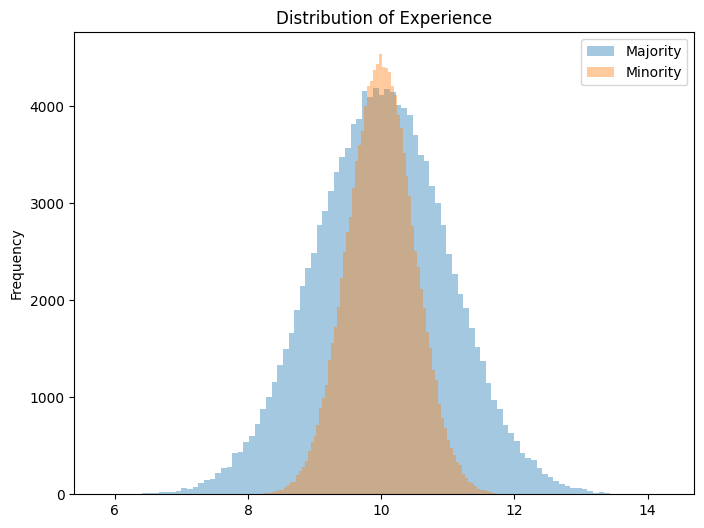

In [8]:
(data.replace({'Minority': {0: 'Majority', 1: 'Minority'}})
 .groupby('Minority')['Experience']
 .plot.hist(
     title="Distribution of Experience",
     bins=100, 
     alpha=0.4, 
     legend=True, 
     figsize=(8, 6)
 )
)

## Constructing a Model

At this point, we assume that the company's data scientist has been tasked with building a model to predict productivity. After working with the data, they decide to use a logistic regression and the two factors we created above. This would be the right thing to do because the logistic regression accurately captures the data generating process created above with all the information available. In other words, _the logistic regression is the best possible model for both minorities and non-minorities._ Any other model, including any machine learning models, or even a deep neural network, would only approximate the fit of this logistic model.

After running the logistic regression, we print some summary output. Note the values of the coefficients at the bottom. We see that the `const` term is close to negative ten, while the `Experience` and `Other Factor` variables' coefficients are close to one. This means the model accurately captures the data generating process for both minorities and non-minorities.

In [9]:
import statsmodels.api as sm

model = sm.Logit(
    data['Highly Productive'], 
    sm.add_constant(data[['Experience', 'Other Factor']])
).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.561537
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Highly Productive   No. Observations:               250000
Model:                          Logit   Df Residuals:                   249997
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.1899
Time:                        07:49:19   Log-Likelihood:            -1.4038e+05
converged:                       True   LL-Null:                   -1.7329e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -9.9596      0.067   -148.158      0.000     -10.091      -9.828
Experience       0.9960      0.007    148.548      0.000       0.983       1.009
Other Factor     0.9955      0.005    183.257      0.000       0.985       1.006
================================================================================
"""

In the step below, we calculate predictions with the model which will be used to calculate differential validity.

In [10]:
data['Predictions'] = model.predict(
    sm.add_constant(data[['Experience', 'Other Factor']])
)

The graph below further shows that the logistic regression has accurately estimated the true data generating process. This can be seen by the fact that the logistic regression's predictions nearly perfectly line up with the true data generating process values along a 45 degree line. While the technical aspects of this are beyond the scope of this notebook, one can say that the model would be flawed if the predictions did not fall along the 45 degree line. Seeing that they do indicates that the model is the best possible model for everyone scored by the model (i.e., it is the best possible model for both minorities and non-minorities).

<Axes: title={'center': 'Predictions vs. True Data Generating Process'}, xlabel='Predictions', ylabel='True Data Generating Process'>

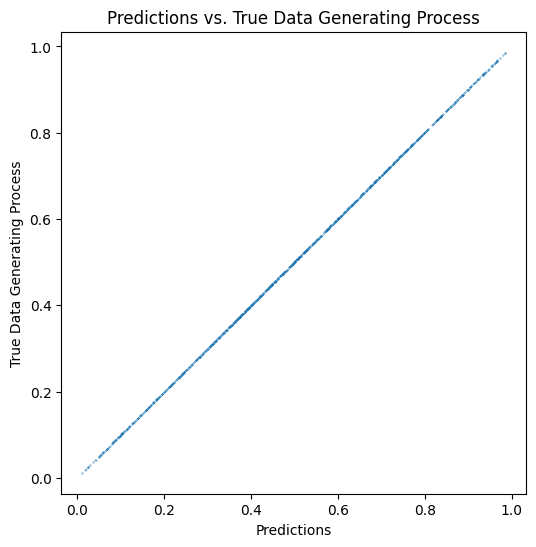

In [11]:
data['True Data Generating Process'] = \
-10 + data['Experience'] + data['Other Factor']
data['True Data Generating Process'] = \
1 / (1 + np.exp(-data['True Data Generating Process']))
data.sample(n=1000).plot.scatter(
    x='Predictions', 
    y='True Data Generating Process', 
    title='Predictions vs. True Data Generating Process', 
    s=0.1,
    figsize=(6, 6),
)

## Calculating Differential Validity

Here, we use **SolasAI's** `custom_disparity_metric` to calculate the ROC-AUC scores for minorities and majority group members. We find that, despite the model being the best possible model for both minorities and non-minorities, we see evidence of differential validity. The AUC for the minority group is about 0.76, while it is about 0.80 for the majority group. This difference, about 5.1%, would likely be cause for concern in a differential validity analysis.

In [12]:
import solas_disparity as sd
from sklearn.metrics import roc_auc_score

relative_auc = sd.custom_disparity_metric(
    group_data=data,
    protected_groups=['Minority'],
    reference_groups=['Majority'],
    group_categories=['Race'],
    metric=roc_auc_score,
    outcome=data['Predictions'],
    label=data['Highly Productive'],
    difference_threshold=lambda difference: difference > 0,
    ratio_threshold=lambda ratio: ratio < 0.95,
)
print_vars = ['Total', 'ROC AUC SCORE', 'Difference', 
              'Ratio', 'Practically Significant']
sd.ui.show(relative_auc.summary_table[print_vars])

Group,Total,ROC AUC SCORE,Difference,Ratio,Practically Significant
Minority,"125,415.0",0.759416,0.041,0.949,Yes
Majority,"124,585.0",0.800539,,,




## Conclusion

People generally assume that a model that shows that a given quality metric is worse for one group means that the model itself is a driver of discrimination. This is not always correct. In this example, we show that the distribution of the data that goes into the model can drive differential validity -- even when the model being used is the best possible model for all groups. This means that measurements of differential validity must be taken with a grain of salt. 

While we have shown that differential validity is not a reliable measure of model-based discrimination, we have not shown that the use of this data in this model is not discriminatory in other ways. In other words, we still should ask, "Is this model discriminatory given that it uses data with unequal variances by group?" The answer is -- maybe. The use of data such as these _can_ drive there to be disparate impact discrimination when the model is used to select employees. In the next notebook in this series, we will show when this model might lead to discriminatory outcomes, and also discuss what can be done to mitigate the discrimination.

If you liked this article, you may like my forthcoming book, co-authored with Ali El-Sharif and Serg Masis, [_Building Responsible AI with Python_](https://www.amazon.com/Building-Responsible-AI-Python-hands-ebook/dp/B0BVZX47Q4/ref=sr_1_1?crid=27UBR7X4I7YM1&keywords=responsible+ai+with+python&qid=1691350830&sprefix=responssible+ai+with+python%2Caps%2C83&sr=8-1). Please take a look and consider pre-ordering it. Also, if you're interested in testing your models for evidence of disparities, like we did above, please consider trying SolasAI's publicly-available disparity testing library, [solas-disparity](https://github.com/SolasAI/solas-ai-disparity).
